In [1]:
import sys

#import params_Jay as params
#params.set_gpu_env()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib

import os
import glob

from sklearn.utils import shuffle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering, OPTICS
from sklearn.cluster import *
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, KernelPCA, NMF
from sklearn.manifold import TSNE
from sklearn import manifold
from umap import UMAP
import plotly.express as px


from scipy.signal import argrelextrema

import pandas as pd

torch.__version__

image_cmap = plt.cm.inferno

/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class recon_encoder(nn.Module):

    def __init__(self, latent_size, nconv=16, pool=4, drop=0.05):
        super(recon_encoder, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),          
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          nn.Dropout(drop),     
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          #nn.Dropout(drop),     
          #nn.ReLU(),
          #nn.MaxPool2d((pool,pool)),
        )


        self.bottleneck = nn.Sequential(
          # FC layer at bottleneck -- dropout might not make sense here
          nn.Flatten(),
          nn.Linear(1024, latent_size),
          #nn.Dropout(drop),
          nn.ReLU(),
#          nn.Linear(latent_size, 1024),
#          #nn.Dropout(drop),
#          nn.ReLU(),
#          nn.Unflatten(1,(64,4,4))# 0 is batch dimension
          )


        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),
            
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Sigmoid() #Amplitude mode
          )
    

    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            x1 = self.bottleneck(x1)
            #print(x1.shape)
            return x1


    #Helper function to calculate size of flattened array from conv layer shapes    
    def calc_fc_shape(self):
        x0 = torch.zeros([256,256]).unsqueeze(0)
        x0 = self.encoder(x0)

        self.conv_bock_output_shape = x0.shape
        #print ("Output of conv block shape is", self.conv_bock_output_shape)
        self.flattened_size = x0.flatten().shape[0]
        #print ("Flattened layer size is", self.flattened_size)
        return self.flattened_size

class recon_model(nn.Module):

    def __init__(self, latent_size, nconv=16, pool=4, drop=0.05):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),          
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          nn.Dropout(drop),     
          nn.ReLU(),
          nn.MaxPool2d((pool,pool)),

          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          #nn.Dropout(drop),     
          #nn.ReLU(),
          #nn.MaxPool2d((pool,pool)),
        )


        self.bottleneck = nn.Sequential(
          # FC layer at bottleneck -- dropout might not make sense here
          nn.Flatten(),
          nn.Linear(1024, latent_size),
          #nn.Dropout(drop),
          nn.ReLU(),
          nn.Linear(latent_size, 1024),
          #nn.Dropout(drop),
          nn.ReLU(),
          nn.Unflatten(1,(64,4,4))# 0 is batch dimension
          )


        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=pool, mode='bilinear'),
            
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          #nn.Dropout(drop),
          #nn.ReLU(),
          #nn.Upsample(scale_factor=pool, mode='bilinear'),

          nn.Conv2d(nconv*2, 1, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Sigmoid() #Amplitude mode
          )
    

    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            x1 = self.bottleneck(x1)
            #print(x1.shape)
            return self.decoder1(x1)


    #Helper function to calculate size of flattened array from conv layer shapes    
    def calc_fc_shape(self):
        x0 = torch.zeros([256,256]).unsqueeze(0)
        x0 = self.encoder(x0)

        self.conv_bock_output_shape = x0.shape
        #print ("Output of conv block shape is", self.conv_bock_output_shape)
        self.flattened_size = x0.flatten().shape[0]
        #print ("Flattened layer size is", self.flattened_size)
        return self.flattened_size

In [3]:
inf_images = np.load('../XPCSData/E031_256.npy').astype(np.float32)
inf_images = inf_images.reshape(-1,1,256,256)

inf_loader = DataLoader(inf_images,batch_size=32,shuffle=False,num_workers=4)

In [4]:
full_model = torch.load('weights/betst_model_100x_0064.pth',map_location=torch.device('cpu'))

summary(full_model,(1,256,256),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             160
           Dropout-2         [-1, 16, 256, 256]               0
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
           Dropout-5         [-1, 16, 256, 256]               0
              ReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,640
           Dropout-9           [-1, 32, 64, 64]               0
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,248
          Dropout-12           [-1, 32, 64, 64]               0
             ReLU-13           [-1, 32, 64, 64]               0
        MaxPool2d-14           [-1, 32,

/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
encoder_model = recon_encoder(latent_size=64)
encoder_state_dict = encoder_model.state_dict()

checkpoint = torch.load('weights/betst_model_100x_0064_statedict.pth',map_location=torch.device('cpu'))
pretrained_dict = {k: v for k, v in checkpoint.items() if k in encoder_state_dict}

encoder_model.load_state_dict(pretrained_dict)

#summary(encoder_model, (1,256,256), device='cpu')

In [ ]:
preds_full = []
preds_enc = []

for i, images in enumerate(inf_loader):
    pred_full = full_model(images)
    pred_enc = encoder_model(images)
    for j in range(images.shape[0]):
        preds_full.append(pred_full[j].detach().to('cpu').numpy())
        preds_enc.append(pred_enc[j].detach().to('cpu').numpy())
    
rheo_decoded = np.array(preds_full).squeeze()
rheo_encoded = np.array(preds_enc)

print(rheo_decoded.shape)
print(rheo_encoded.shape)

In [5]:
#np.save('/Users/jhorwath/Documents/XPCS_Analysis/Intermittent_Dynamics/rheo_encoded.npy',rheo_encoded)
#np.save('/Users/jhorwath/Documents/XPCS_Analysis/Intermittent_Dynamics/rheo_decoded.npy',rheo_decoded)

rheo_encoded = np.load('/Users/jhorwath/Documents/XPCS_Analysis/Intermittent_Dynamics/rheo_encoded.npy',mmap_mode='r+')
rheo_decoded = np.load('/Users/jhorwath/Documents/XPCS_Analysis/Intermittent_Dynamics/rheo_decoded.npy',mmap_mode='r+')

print(rheo_encoded.shape)
print(rheo_decoded.shape)

(900, 64)
(900, 256, 256)


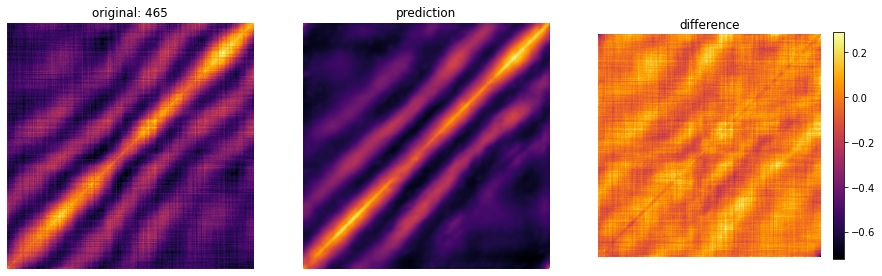

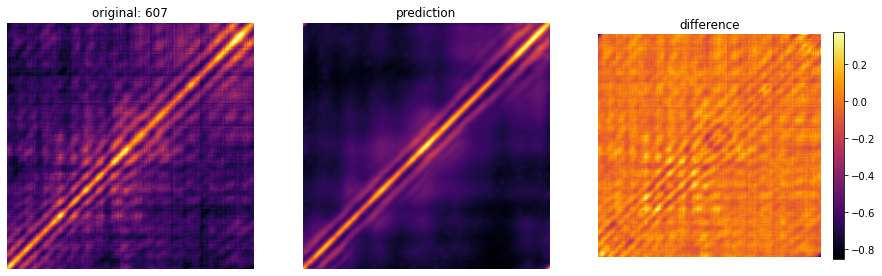

In [6]:
test_images = [465,607]
image_cmap = plt.cm.inferno

for i in range(len(test_images)):
    
    fig, ax = plt.subplots(1,3,figsize=(15,10))
    ax[0].imshow(inf_images[test_images[i],0],image_cmap,origin='lower')
    ax[0].axis('off')
    ax[0].set_title('original: {}'.format(test_images[i]))
    
    ax[1].imshow(rheo_decoded[test_images[i]],image_cmap,origin='lower')
    ax[1].axis('off')
    ax[1].set_title('prediction')
    
    g = ax[2].imshow(inf_images[test_images[i],0] - rheo_decoded[test_images[i]],image_cmap,origin='lower')
    ax[2].axis('off')
    ax[2].set_title('difference')
    fig.colorbar(g,ax=ax[2],fraction=0.046,pad=0.05)
    
#    fig.savefig('new_figures/sample_recon_{:04d}.svg'.format(test_images[i]))

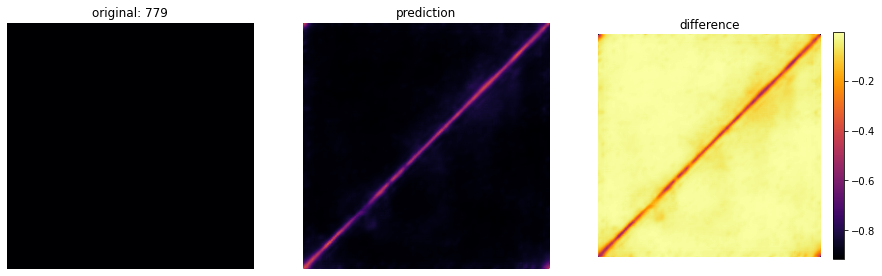

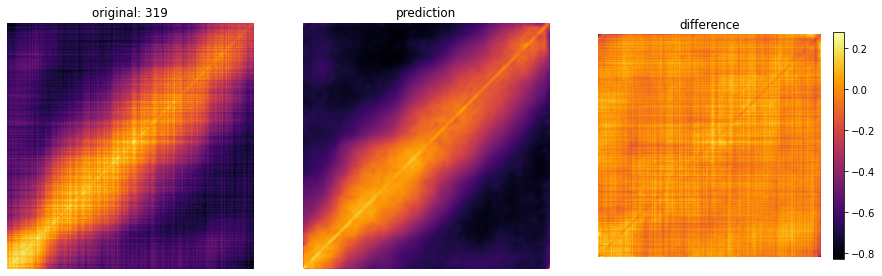

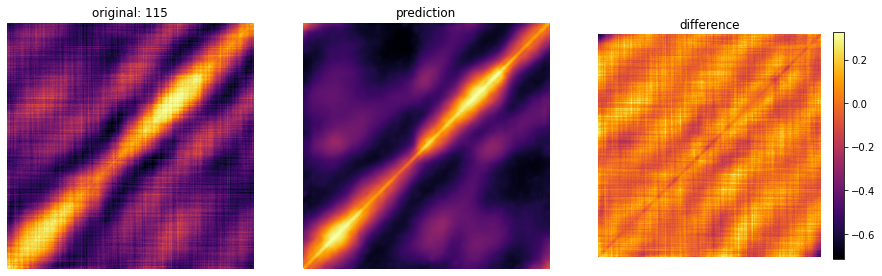

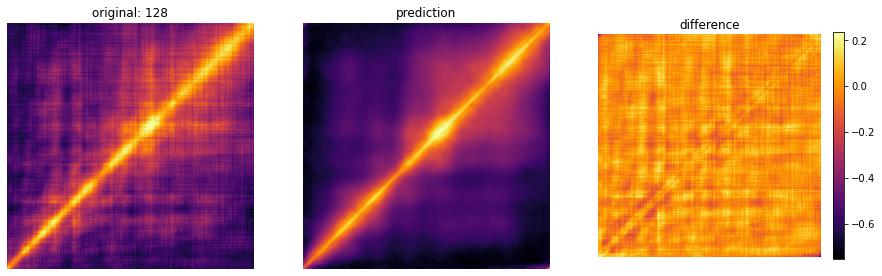

In [7]:
test_images = np.random.choice(np.arange(len(rheo_decoded)),size=(4),replace=False)

for i in range(len(test_images)):
    
    fig, ax = plt.subplots(1,3,figsize=(15,10))
    ax[0].imshow(inf_images[test_images[i],0],image_cmap,origin='lower')
    ax[0].axis('off')
    ax[0].set_title('original: {}'.format(test_images[i]))
    
    ax[1].imshow(rheo_decoded[test_images[i]],image_cmap,origin='lower')
    ax[1].axis('off')
    ax[1].set_title('prediction')
    
    g = ax[2].imshow(inf_images[test_images[i],0] - rheo_decoded[test_images[i]],image_cmap,origin='lower')
    ax[2].axis('off')
    ax[2].set_title('difference')
    fig.colorbar(g,ax=ax[2],fraction=0.046,pad=0.05)
    
#    fig.savefig('new_figures/sample_recon_{:04d}.svg'.format(test_images[i]))